# Lab 1 Report

# Imports and General Functions

In [118]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import glob
import math

def zeros(n, dtype=int):
    return [dtype(0.0)] * n

def my_avg(x, dtype=float):

    tot = float(0)
    for i in x:
        tot += i

    m =  tot/len(x)
    return m

def my_std(x, dtype=float): # take an empty array and spit out an array with the mean counts of one image of each exposure time
    m = my_avg(x)
    tot = float(0)
    for i in x:

        tot += (i-m)**2

    return (tot/len(x))**0.5

def ascend_str(ls, idxs):
    idx = 0
    idx_slice = slice(idxs[0], idxs[1])  # make slice for desired indices
    while idx < len(ls):
        for i, x in enumerate(ls):
            if i > idx and int(x[idx_slice]) < int(ls[idx][idx_slice]):  # check for lowest integer at given indices
                ls[i], ls[idx] = ls[idx], x

        idx += 1
    return None

def get_exp(x):
    with fits.open(x) as hdu:
        hdr = hdu[0].header
    return hdr['EXPTIME']

def set_negatives_to_zero_nd(tensor):
    """
    sets negative values to 0 inplace for a rank n tensor
    """
    # check for rank 1
    ele = tensor[0]
    if isinstance(ele, np.ndarray):
        # not inside rank 1 yet so recursively loop with self call
        for sub in tensor:
            set_negatives_to_zero_nd(sub)
    else:
        # we are inside the rank 1 now
        for i, val in enumerate(tensor):
            if val < 0:                         # if less than zero
                tensor[i] = 0                   # set to zero
    return None

def poisson_log(x, mu):
    """
    Logarithmic approximation of Poisson distribution to avoid overflow error
    :param x: float, x value, must be positive
    :param mu: float, mean of the distribution
    :return: approximate value of the Poisson distribution
    """
    if x==0:
        log = -mu
    else:
        log = x * (math.log(mu) - math.log(x)) + x - mu
    return math.exp(log)


def get_poisson(data, xrange=None):
    fdata = data.flatten()
    mu = avg(fdata)
    if xrange is None:
        x_min = int(fdata.min())
        x_max = int(fdata.max())
    else:
        x_min, x_max = xrange

    x_values = np.arange(x_min, x_max + 1)

    p_values = [poisson_log(x, mu) for x in x_values]

    return x_values, p_values

# Master Bias Frame

In [119]:
bias_frames = glob.glob('Lab1_data/d20[0-1][0-9].fits')

def bias(x):
    n = len(x)
    tot = zeros(n, dtype=float)

    for i, file in enumerate(x):
        arr = fits.getdata(file)
        tot[i] = arr
    avg = my_avg(tot)
    return avg

biasdat = bias(bias_frames)

# Bias Subtraction

In [67]:
def bias_sub(x):
    n = len(x)
    tot = zeros(n, dtype=float)

    for i, file in enumerate(x):
        arr = fits.getdata(file)
        tot[i] = arr - biasdat
    return tot

frames = glob.glob('Lab1_data/d20[4-8][0-9].fits')
ascend_str(frames, (-7,-5))
allframes = bias_sub(frames)
set_negatives_to_zero_nd(allframes)
np.min(allframes)

np.float64(0.0)

# ImShow

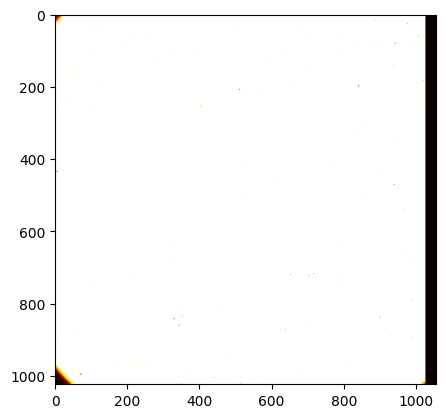

In [68]:
np.shape(allframes)
plt.imshow(fits.getdata(frames[-6]), cmap='hot')
plt.show()

# Exposure Frames

In [112]:
def exp_frames(x):
    tot = []
    for i in range(0,len(x),5):
        tot.append(x[i])
    return tot

exp_frames = exp_frames(allframes)
type(exp_frames)


list

# Histograms

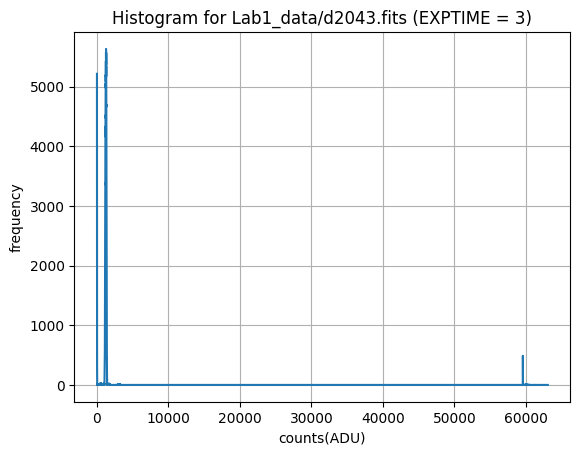

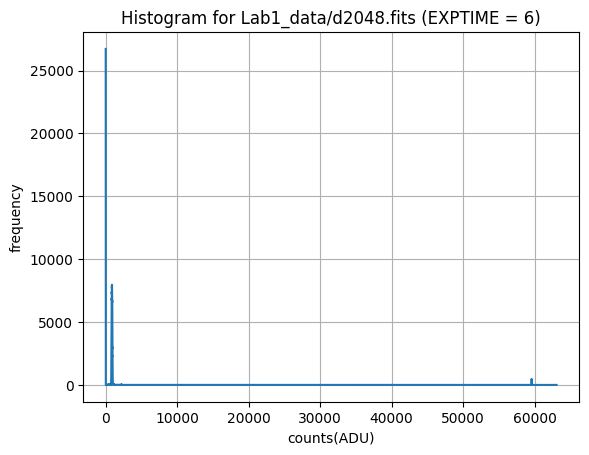

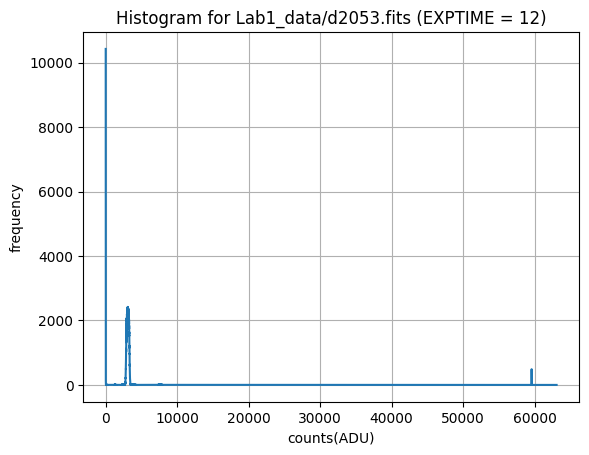

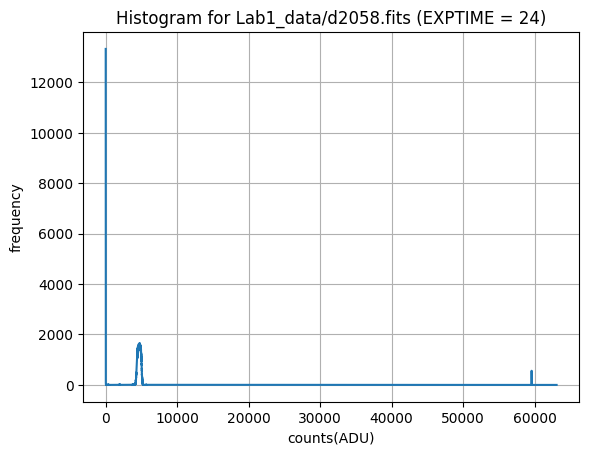

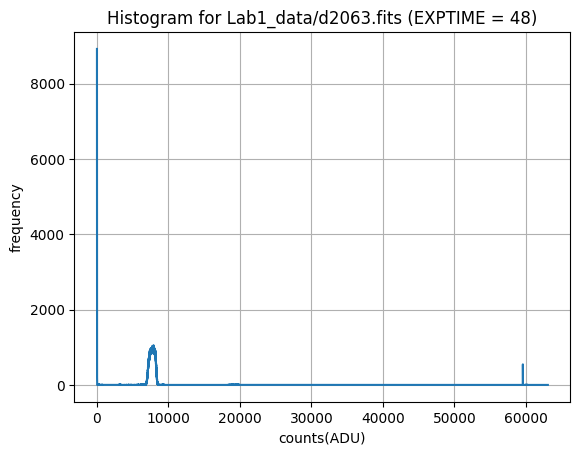

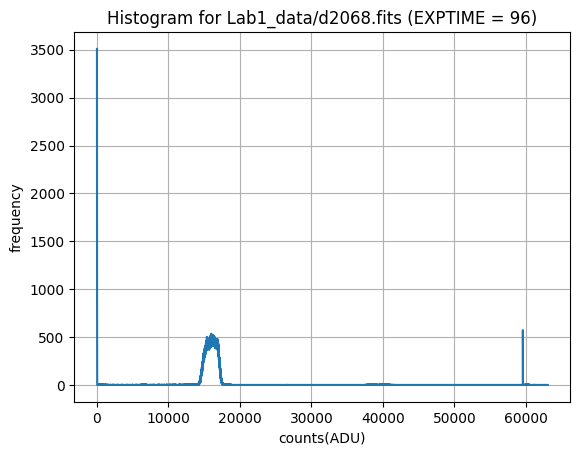

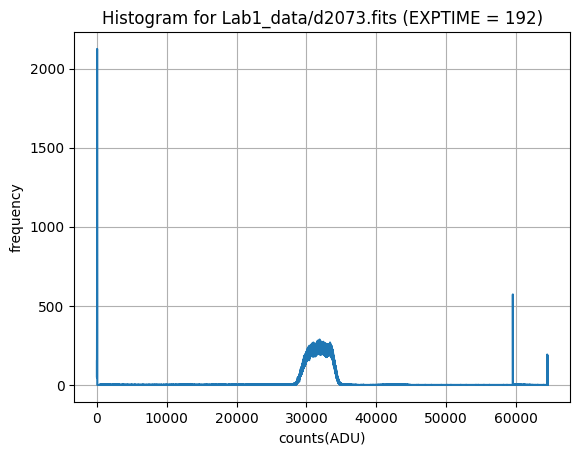

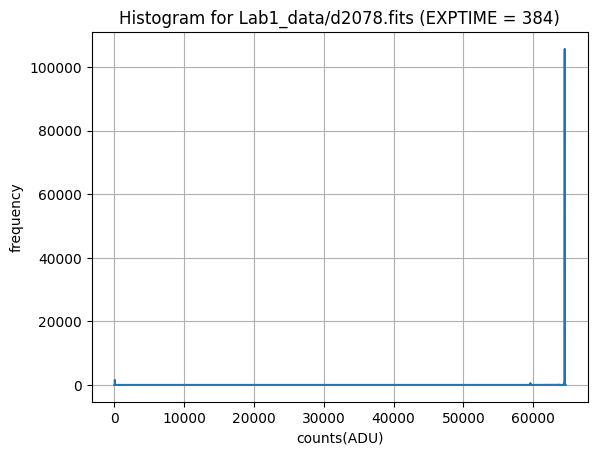

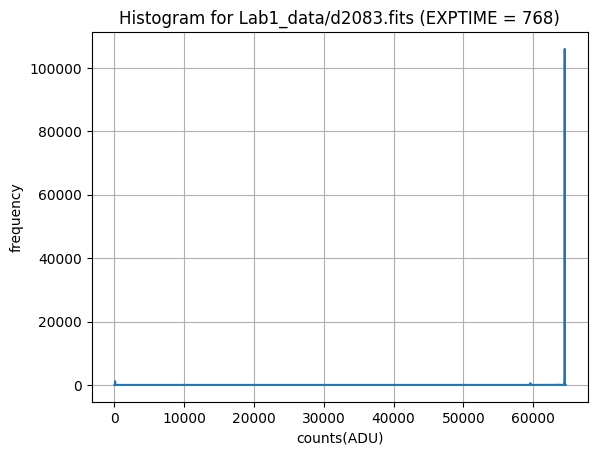

In [131]:
def histogram(file): # Function for creating a histogram of the desired filename

    farr = file.flatten()

    hmin = int(farr.min())
    hmax = int(farr.max())

    # initialize bins and empty count x[i]
    hr = np.arange(hmin, hmax + 1)
    hist = np.zeros(hmax - hmin + 1, dtype=int)

    # count each value in bins
    for value in farr:
        if hmin <= value <= hmax:
            hist[int(value - hmin)] += 1

    return hr, hist




for i, data in enumerate(exp_frames):

    idx = int(i*5)
    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)
    plt.plot(hr, hist)
    plt.xlabel('counts(ADU)')
    plt.ylabel('frequency')
    plt.title(f'Histogram for {frames[idx]} (EXPTIME = {exp_time})')
    plt.grid()
    plt.show()


# Mean

In [120]:
for x in exp_frames:
    print(my_avg(x.flatten()))

1269.3638625131825
906.256772800536
3056.027037985674
4594.8038602464685
7545.112027255065
15550.563933905192
30852.349244258454
62422.86850580667
62468.133533401975


# Standard Deviation

In [121]:
for x in exp_frames:
    print(my_std(x.flatten()))

1802.5190277360805
1796.3029443204541
1819.4340861733062
1919.3013212322319
2187.584943253094
3350.3835377082
5986.536440672533
11252.452006709742
11173.80191233922


# Mean vs. Standard Deviation Plot

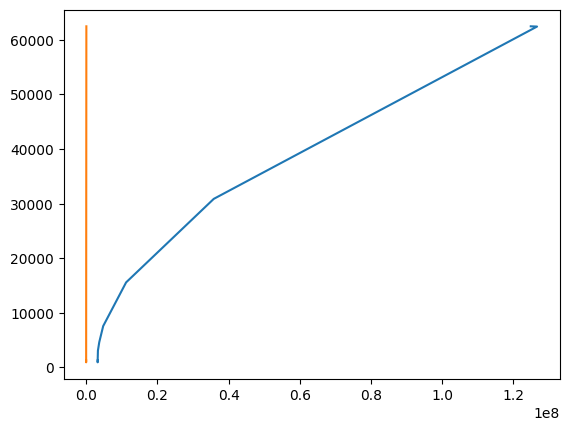

In [122]:
avg = zeros(len(exp_frames), dtype=float)
dev = zeros(len(exp_frames), dtype=float)


for i,x in enumerate(exp_frames):
    avg[i] = my_avg(x.flatten())
    dev[i] = my_std(x.flatten())

devsqr = list(map(lambda x: x**2, dev))

fig, ax = plt.subplots()

ax.plot(devsqr,avg)
ax.plot(avg,avg)
plt.show()

# Log Log Plot

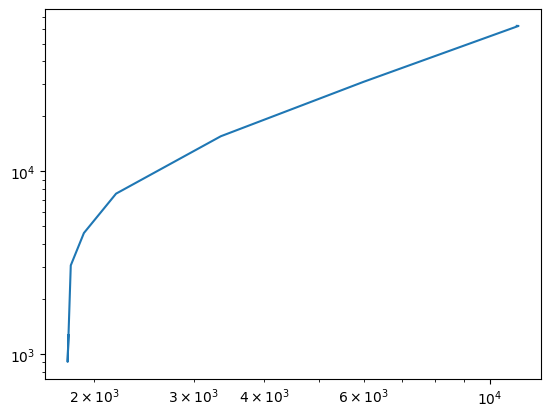

In [74]:
plt.loglog(dev,avg)
plt.show()

# Flat Frame Division

In [111]:
def ffdiv(x,file):
    exp = get_exp(file)
    return x/exp


reduced_flats = zeros(len(allframes), dtype=float)
for i,x in enumerate(allframes):
    reduced_flats[i] = ffdiv(x,frames[i])
np.shape(reduced_flats)
type(reduced_flats)

list

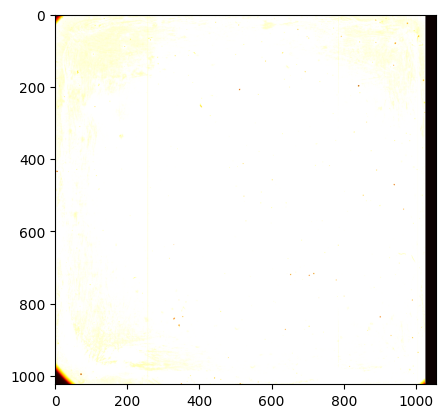

In [76]:
plt.imshow(reduced_flats[-4], cmap='hot')
plt.show()

# MOM & SDOM

In [123]:
n = len(reduced_flats)
means = []
MOMs = zeros(n, dtype=float)
SDOMs = zeros(n, dtype=float)

for i,x in enumerate(reduced_flats):
    fx = x.flatten()
    means.append(my_avg(fx))
    MOM = my_avg(means)
    SDOM = my_std(means)
    MOMs[i] = MOM
    SDOMs[i] = SDOM


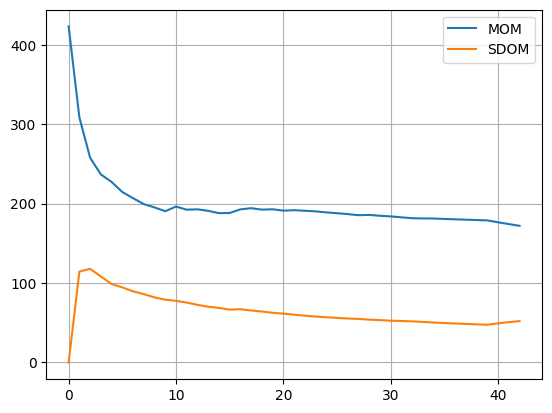

In [124]:
num_frames = np.arange(0,len(allframes))

fig, ax = plt.subplots()
ax.plot(num_frames,MOMs, label='MOM')
ax.plot(num_frames,SDOMs, label='SDOM')
plt.grid()
ax.legend()
plt.show()

# Poisson Distribution

In [133]:
def poisson_log(x, mu):
    """
    Logarithmic approximation of Poisson distribution to avoid overflow error
    :param x: float, x value, must be positive
    :param mu: float, mean of the distribution
    :return: approximate value of the Poisson distribution
    """
    if x==0:
        log = -mu
    else:
        log = x * (math.log(mu) - math.log(x)) + x - mu
    return math.exp(log)

def get_poisson(data, xrange=None):
    fdata = data.flatten()
    mu = my_avg(fdata)
    if xrange is None:
        x_min = int(fdata.min())
        x_max = int(fdata.max())
    else:
        x_min, x_max = xrange

    x_values = np.arange(x_min, x_max + 1)

    p_values = [poisson_log(x, mu) for x in x_values]

    return x_values, p_values

def poisson_plot(file):

    farr = file.flatten()

    hmin = int(farr.min())
    hmax = int(farr.max())

    # initialize bins and empty count x[i]
    hr = np.arange(hmin, hmax + 1)
    hist = np.zeros(hmax - hmin + 1, dtype=int)

    # count each value in bins
    for value in farr:
        if hmin <= value <= hmax:
            hist[int(value - hmin)] += 1

    return hr, hist



    #plt.plot(hr,hist)
    #plt.plot(get_poisson(file))
    #plt.xlim(0,2000)
    #plt.grid(True)
    #plt.xlabel('counts(ADU)')
    #plt.ylabel('frequency')
    #plt.show()


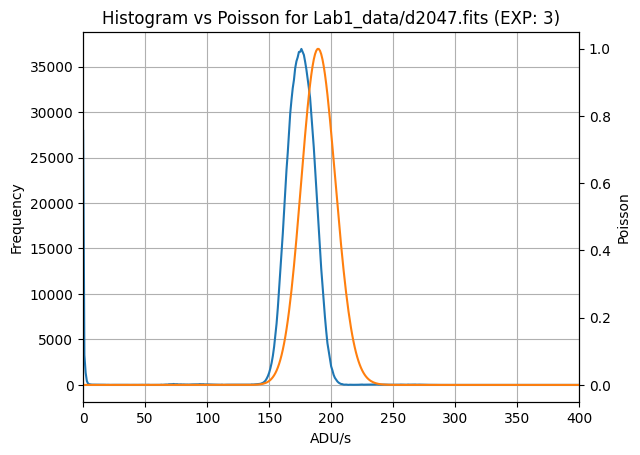

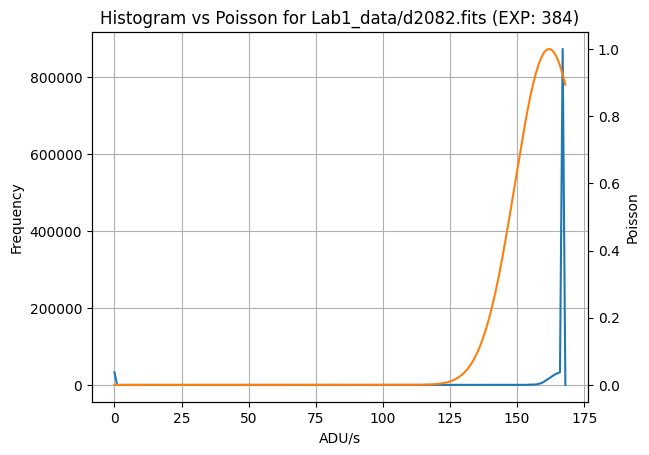

In [134]:
chosen_frames = (reduced_flats[4], reduced_flats[-4])
for i, data in enumerate(chosen_frames):
    idx = int(-8*i + 4)
    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)

    x, p = get_poisson(data)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(hr, hist, label='Histogram', color='tab:blue')
    ax2.plot(x, p, label='Poisson', color='tab:orange')

    if i==0:
        plt.xlim(0, 400)

    ax1.grid()
    ax1.set_xlabel('ADU/s')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Poisson')
    ax.legend()
    plt.title(f'Histogram vs Poisson for {frames[idx]} (EXP: {exp_time})')
    plt.show()


# Mean and Standard Deviation of Poisson fit files

In [137]:
for i,data in enumerate(chosen_frames):
    fdata = data.flatten()
    idx = int(-8*i + 4)
    name = frames[idx]
    exp_time = get_exp(name)
    mean = my_avg(fdata)
    std = my_std(fdata)
    print(f'Frame: {name}, EXP: {exp_time}')
    print(f'Mean: {mean}')
    print(f'STD: {std}')
    print('-------------------------')


Frame: Lab1_data/d2047.fits, EXP: 3
Mean: 189.4925361402166
STD: 603.3185299172932
-------------------------
Frame: Lab1_data/d2082.fits, EXP: 384
Mean: 161.9245125080526
STD: 29.283887693633396
-------------------------


# Gaussian Plots